# OLS Regression on daily maximum temperatures in Charlottesville, VA
  
## 1. Importing Packages

In [ ]:
# Import packages
import earthpy
import holoviews as hv
import hvplot.pandas
import pandas as pd
import numpy as np

# Advanced options on matplotlib/seaborn/pandas plots
import matplotlib.pyplot as plt
# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression

## 2. Downloading & Formatting Data

In [ ]:
# Create Charlotteville URL variable using the USC00441593 Station
cville_url = ('https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily'
'-summaries&dataTypes=TMAX&stations=USC00441593&startDate=1893-01-01&endDate'
'=2024-12-31&units=standard')
cville_url

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TMAX&stations=USC00441593&startDate=1893-01-01&endDate=2024-12-31&units=standard'

In [26]:
# Download the climate data
cville_raw_df = pd.read_csv(
    cville_url,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check that the download worked
cville_raw_df.head()

,STATION,TMAX
DATE,,
1893-01-01,USC00441593,44.0
1893-01-02,USC00441593,NaN
1893-01-03,USC00441593,36.0
1893-01-04,USC00441593,28.0
1893-01-05,USC00441593,23.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45366 entries, 1893-01-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  45366 non-null  object 
 1   TMAX     45161 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


<Axes: ylabel='Frequency'>

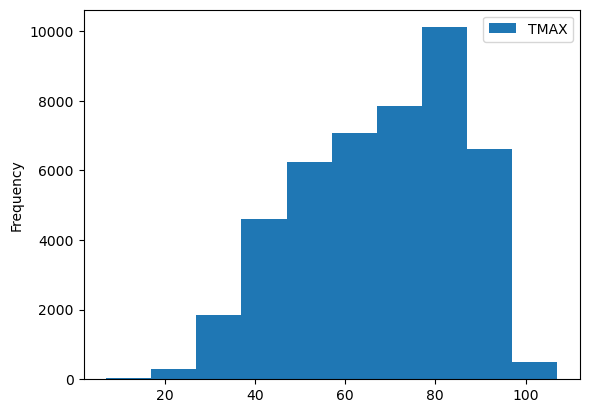

In [ ]:
# Confirming data type, information, and that NaN values are handled correctly
type(cville_raw_df)

cville_raw_df.info()

cville_raw_df.plot.hist()

In [35]:
# Removing the Station ID column since it does not change
cville_df = cville_raw_df[["TMAX"]]

# Adding column for celsius conversion, rounding to three decimals
cville_df['Max_Celsius'] = round((cville_df['TMAX']-32) * (5/9), 3)
cville_df


,TMAX,Max_Celsius
DATE,,
1893-01-01,44.0,6.667
1893-01-02,NaN,NaN
1893-01-03,36.0,2.222
1893-01-04,28.0,-2.222
1893-01-05,23.0,-5.000
...,...,...
2024-12-27,49.0,9.444
2024-12-28,43.0,6.111
2024-12-29,62.0,16.667


In [40]:
# Remove TMAX column after confirming calculation accuracy
cville_df = cville_df[["Max_Celsius"]]
cville_df

,Max_Celsius
DATE,
1893-01-01,6.667
1893-01-02,NaN
1893-01-03,2.222
1893-01-04,-2.222
1893-01-05,-5.000
...,...
2024-12-27,9.444
2024-12-28,6.111
2024-12-29,16.667


## 3. Plotting & Resampling

<Axes: title={'center': 'Charlottesville Daily Max Temp 1893 - 2024'}, xlabel='Year', ylabel='Temperature  ($^\\circ$C)'>

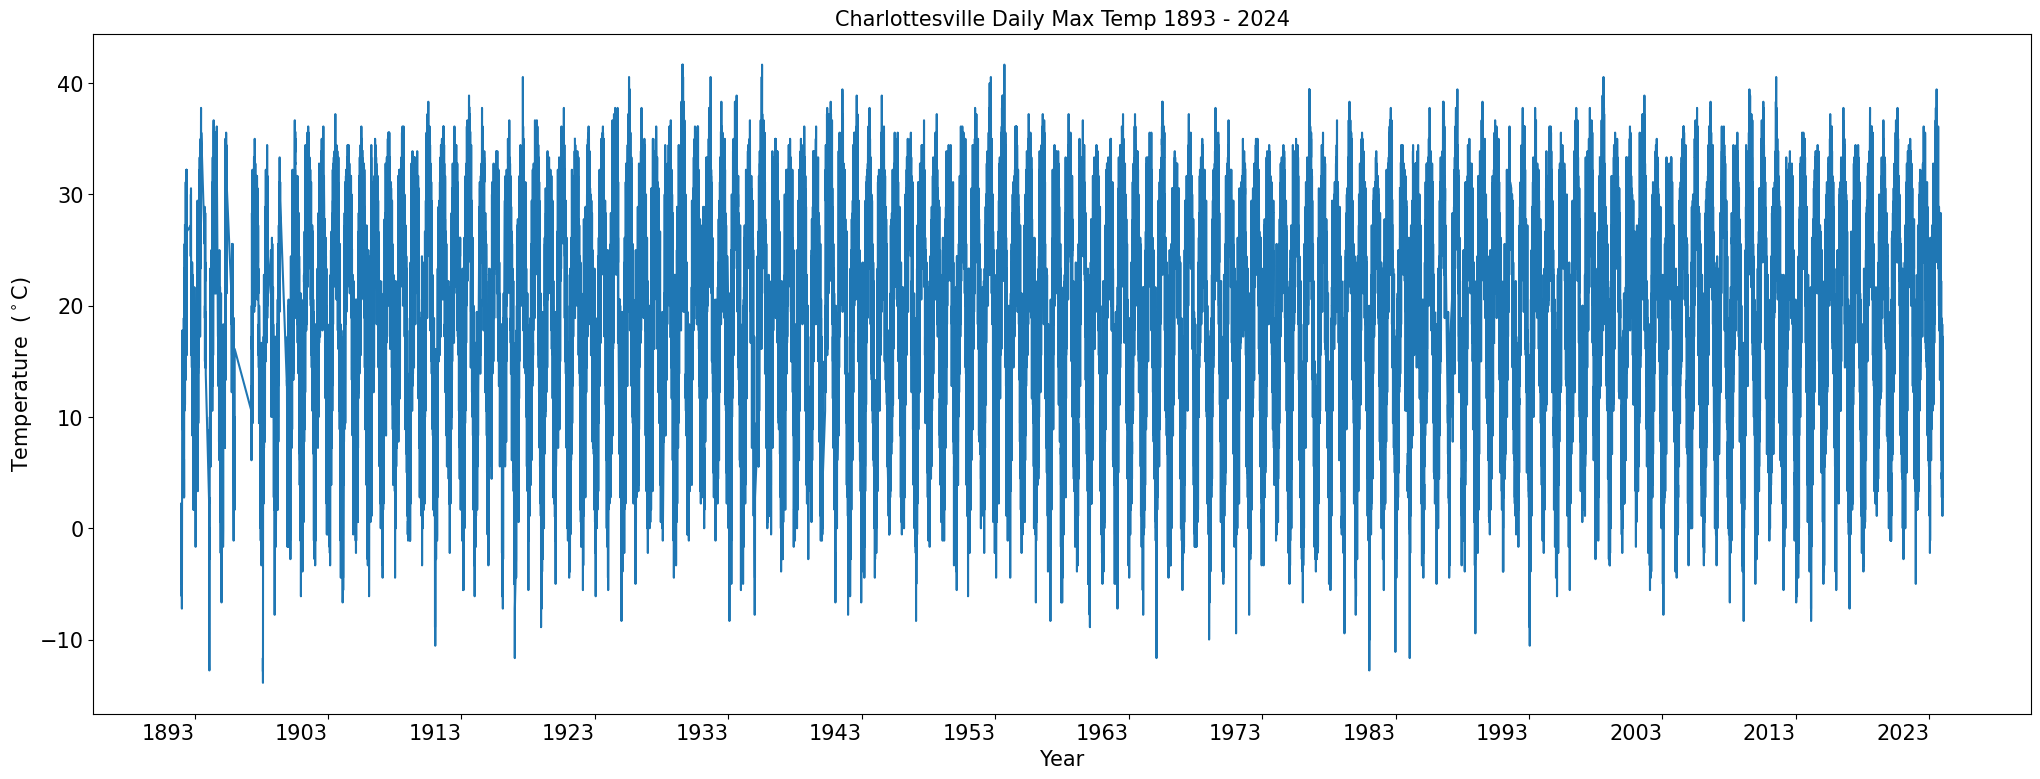

In [74]:
# Plot all daily data points
cville_plot = cville_df.plot(
    y='Max_Celsius',
    legend=False,
    fontsize=15,
    figsize=(25,10)
    )

# Change titles and axis label font sizes directly when changing figsize
cville_plot.set_title('Charlottesville Daily Max Temp 1893 - 2024', fontsize=15)
cville_plot.set_xlabel('Year', fontsize=15)
cville_plot.set_ylabel('Temperature  ($^\circ$C)', fontsize=15)

# Generate x axis label every 10 years instead of 20
xlabels = pd.date_range(start=cville_df.index.min(), end=cville_df.index.max(), 
                       freq='10YE')

# Set the ticks to the plot
cville_plot.set_xticks(xlabels)

# Format x axis labels to show only the year
cville_plot.set_xticklabels([tick.year for tick in xlabels])

# Rotate x axis labels
plt.setp(cville_plot.xaxis.get_majorticklabels(), rotation=0)

cville_plot


In [148]:
# Cut off years with less than 330 observations (~2 total missing months)

# Add column for year
cville_df['year']=cville_df.index.year

# Establish variables for counts and cutoffs
counts = cville_df['year'].value_counts()
valid_years = counts[counts >= 300].index
invalid = counts[counts < 300].index

# Filter out invalid years
cville_df_clean = cville_df[cville_df['year'].isin(valid_years)].copy()

# Remove the year column
cville_df_clean = cville_df_clean[["Max_Celsius"]]

print(invalid)
cville_df_clean

Index([1899, 1988, 1916, 1898, 1893, 1896, 1894, 1900], dtype='int32', name='year')


,Max_Celsius
DATE,
1895-02-01,2.222
1895-02-02,2.778
1895-02-03,-2.778
1895-02-04,2.222
1895-02-05,-3.333
...,...
2024-12-27,9.444
2024-12-28,6.111
2024-12-29,16.667


In [149]:
# Resampling data to calculate average annual value
ann_cville_df = (
    cville_df_clean
    .resample('YS')
    .mean()
)
ann_cville_df

,Max_Celsius
DATE,
1895-01-01,19.621053
1896-01-01,NaN
1897-01-01,NaN
1898-01-01,NaN
1899-01-01,NaN
...,...
2020-01-01,19.959030
2021-01-01,20.465756
2022-01-01,19.737522


<Axes: title={'center': 'Charlottesville Average Daily Max Temp 1901 - 2024'}, xlabel='Year', ylabel='Temperature  ($^\\circ$C)'>

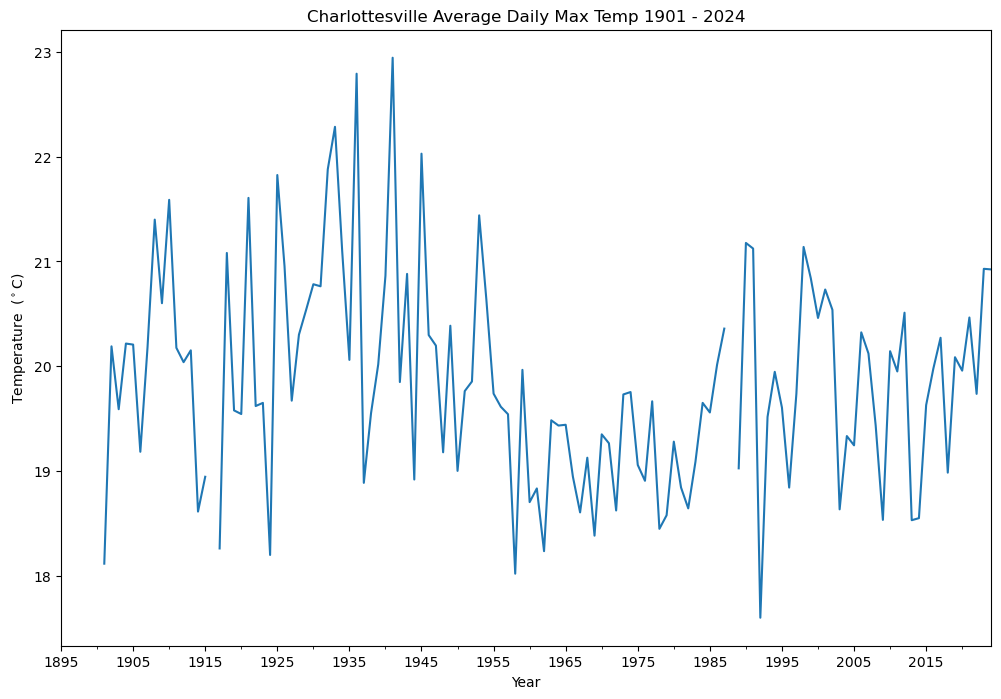

In [150]:
# Plot
ann_cville_plot = ann_cville_df.plot(
    y='Max_Celsius',
    legend=False,
    fontsize=10,
    figsize=(12,8)
    )

# Change titles and axis label font sizes directly when changing figsize
ann_cville_plot.set_title('Charlottesville Average Daily Max Temp 1901 - 2024', fontsize=12)
ann_cville_plot.set_xlabel('Year', fontsize=10)
ann_cville_plot.set_ylabel('Temperature  ($^\circ$C)', fontsize=10)

# Generate x axis label every 10 years instead of 20
xlabels = pd.date_range(start=ann_cville_df.index.min(), end=ann_cville_df.index.max(), 
                       freq='10YE')

# Set the ticks to the plot
ann_cville_plot.set_xticks(xlabels)

# Format x axis labels to show only the year
ann_cville_plot.set_xticklabels([tick.year for tick in xlabels])

# Rotate x axis labels
plt.setp(ann_cville_plot.xaxis.get_majorticklabels(), rotation=0)

ann_cville_plot


In [151]:
# Interactive plot

cville_int_plot = ann_cville_df.hvplot(
    title='Charlottesville Average Daily Max Temp 1901 - 2024',
    y='Max_Celsius',
    ylabel='Temperature (°C)',
    xlabel='Year',
    legend=False,
)

cville_int_plot

:Curve   [DATE]   (Max_Celsius)

In [147]:
# Fit an OLS Linear Regression to the data

# Drop years missing data from analysis
ann_cville_df = ann_cville_df.dropna()

# Define variables
x = ann_cville_df.index.year.values.reshape(-1, 1)
y = ann_cville_df['Max_Celsius']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Calculate and print slope
print(f'Slope: {model.coef_[0]} degrees per year')

Slope: 0.004803050372804026 degrees per year
